In [1]:
import cv2
import log_reg
import numpy as np
from glob import glob
from matplotlib.pyplot import imread, imshow
from util import read_X_Y, get_data_col, filter_data_by_colval
from keras.models import Sequential 
from keras.layers import Dense, Activation, Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#TensorBoard
from keras.callbacks import TensorBoard, ModelCheckpoint
from time import time
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')



#For UNet
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


/Users/hugo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
file_names = sorted(glob('all-mias/*.pgm'))
# print(file_names)

In [3]:
headers = ['file_name', 'character', 'class', 'severity', 'x', 'y', 'radius']
filtered_X, Y_headers,Y_names, Ben_Mag = read_X_Y('dataset/data.txt',headers)

In [4]:
print(len(filtered_X))

326


In [5]:
#Preprocessing is now being exmpanded to include NORM files and calcification data
def get_filtered_data(fname, sep=' '):
    # some calcified data have multiple tumors in image and the data comes with multiple centers and radii
    overlay_data = {} # col[0] --> [np.array(cols[4],cols[5],cols[6]), ]
    filtered_X_fnames = []
    filtered_base_fnames = []
    ben_mag_data = {} # B, M, -1 (for N/A)
    with open(fname) as f:
        for line in f:
            line = line.strip()
            cols = line.split(sep)

            if len(cols) == 7 and not cols[2] == 'NORM':
                if int(cols[6]) > 50:
                    filtered_X_fnames.append('all-mias/' + cols[0] + '.pgm')
                    filtered_base_fnames.append(cols[0])


                    # add the overlay point
                    overlay_point = np.array( [float(cols[4]),
                                 float(cols[5]),
                                float(cols[6])] ).reshape((3,1))
                    if cols[0] in overlay_data:    
                        overlay_data[cols[0]].append(overlay_point);
                        ben_mag_data[cols[0]].append(cols[3]);
                    else:
                        overlay_data[cols[0]] = [overlay_point];
                        ben_mag_data[cols[0]] = [cols[3]]
#             elif len(cols) == 3 and cols[2] == 'NORM':
                
#                 filtered_X_fnames.append('all-mias/' + cols[0] + '.pgm')
#                 filtered_base_fnames.append(cols[0])
                
#                 overlay_point = np.array( [0.0,0.0,0.0] ).reshape((3,1))
#                 overlay_data[cols[0]] = [overlay_point];
#                 ben_mag_data[cols[0]] = ['N']
#     print(filtered_X_fnames)
#     print(filtered_base_fnames)
    return filtered_X_fnames, overlay_data, filtered_base_fnames, ben_mag_data

#Updated now to deal with
# Y type: dict
# Y_save_path: array
def up_produce_y_mask(overlay_data,filtered_base_fnames, ben_mag_data, color):
    # color: [B:int(0-255), F:int(0-255), N:int(0-255)]
    for fname in filtered_base_fnames:

        overlay_data_point = overlay_data[fname]
        image = np.zeros((1024,1024,1))
        for index, overlay_point in enumerate(overlay_data_point):
            #update this with Color pallete and then test.
            cv2.circle(image, (int(overlay_point[0]),1024-int(overlay_point[1])),int(overlay_point[2]),color[ben_mag_data[fname][index]],-1)
        name = 'mias_y_masked/' + fname + '.png'
        cv2.imwrite(name, image)

filtered_X, overlay_data,filtered_base_fnames, Ben_Mag = get_filtered_data('dataset/data.txt')   

# up_produce_y_mask(overlay_data,filtered_base_fnames, Ben_Mag, {'B': 255, 'M': 255, 'N': 0})

In [6]:
image_stack = np.array([imread(file_name) for file_name in filtered_X])

In [7]:
def produce_y_mask(Y,Y_names):
    for i in range(len(Y)):
        image = np.zeros((1024,1024,1))
        cv2.circle(image, (int(Y[i][0]),1024-int(Y[i][1])),int(Y[i][2]),(255),-1)
        name = 'mias_y_masked/' + Y_names[i] + '.png'
        cv2.imwrite(name, image)

In [8]:
Y_mask_filenames = ['mias_y_masked/' + file_name + '.png' for file_name in filtered_base_fnames]
# print(filtered_base_fnames)
Y = np.array([imread(file_name) for file_name in Y_mask_filenames])
# print(Y.shape)

In [9]:
first = Y[0,:,:]
print(np.nonzero(first))
print(first[np.nonzero(first)])
print(first[402,535])
print(first[first > 1])

(array([402, 403, 403, ..., 795, 795, 796]), array([535, 516, 517, ..., 553, 554, 535]))
[1. 1. 1. ... 1. 1. 1.]
1.0
[]


In [10]:
Y = np.array(Y)
Y = np.squeeze(Y)
m,l,h = image_stack.shape

# print(image_stack.shape)
# X = image_stack.reshape((m,l,h,1))
# Y = Y.reshape((m,l,h,1))

X = image_stack.reshape((m,l,h,1))
Y = Y.reshape((m,l,h,1))


X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.6,random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test,Y_test,train_size=0.5,random_state=42)

# Y_train = np.reshape(Y_train, ())

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)



(24, 1024, 1024, 1)
(24, 1024, 1024, 1)
(8, 1024, 1024, 1)
(8, 1024, 1024, 1)
(8, 1024, 1024, 1)
(8, 1024, 1024, 1)


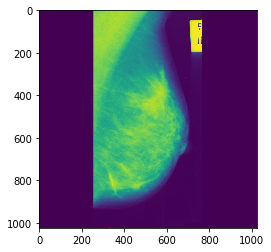

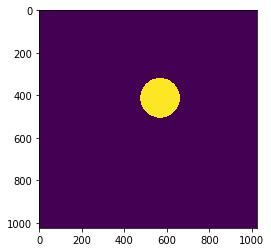

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow

a = 10
x = X_train[a:a+1,:,:,:]
x = np.reshape(x, (1024,1024))
plt.imshow(x)
plt.show()

y = Y_train[a:a+1,:,:]
# print(y)
y = np.reshape(y, (1024,1024))
plt.imshow(y)
plt.show()


In [12]:
#Taken from https://stackoverflow.com/questions/45947351/how-to-use-tensorflow-metrics-in-keras

def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [13]:
#Taken from https://stackoverflow.com/questions/45947351/how-to-use-tensorflow-metrics-in-keras

@as_keras_metric
def mean_iou(y_true, y_pred, num_classes=2):
    return tf.metrics.mean_iou(y_true, y_pred, num_classes)


In [14]:
#Taken from https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d

"""
A weighted version of categorical_crossentropy for keras (2.0.6). This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


In [15]:
# From https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96

from keras import backend as K

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


In [16]:
# For cbis without to_categorical
# Sajana, from https://github.com/zhixuhao/unet

inputs = Input((l,h,1))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
# reshape2d = Reshape((1048576,2))(conv9)
# reshape2d = Dense(1048576)(reshape2d)
# foutput = Activation('sigmoid')(reshape2d)
# model.add(Activation('softmax'))

# conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
# # foutput = Reshape((1048576,1))(conv10)
# model = Model(input = inputs, output = foutput)

conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = 'Adam', loss = jaccard_distance_loss, metrics = [mean_iou])



tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.summary()
#model.fit(X_train,Y_train,epochs=20, validation_data=(X_val, Y_val), batch_size=1,verbose=1, callbacks=[tensorboard])




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 1024, 6 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1024, 1024, 6 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 512, 512, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [17]:
# Code following the template (with some modifications) from https://keras.io/preprocessing/image/

from keras.preprocessing.image import ImageDataGenerator

# we create two instances with the same arguments
data_gen_args = dict(rotation_range=360)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
# image_datagen.fit(X_train, augment=True, seed=seed)
# mask_datagen.fit(Y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(
    X_train,
    batch_size=1,
    seed=seed)

mask_generator = mask_datagen.flow(
    Y_train,
    batch_size=1,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

# model.fit_generator(
#     train_generator,
#     steps_per_epoch=2000,
#     epochs=50)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
filepath = 'unet_weights.{epoch:02d}-{val_mean_iou:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_iou', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# model.fit(X_train,Y_train,epochs=5, validation_data=(X_val, Y_val), batch_size=1,verbose=1, callbacks=[tensorboard, checkpoint])
model.fit_generator(train_generator, steps_per_epoch=300, epochs=10, callbacks=[tensorboard, checkpoint], validation_data=(X_val, Y_val), class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)

Epoch 1/10
  2/300 [..............................] - ETA: 14:32:29 - loss: 0.6444 - mean_iou: 0.1346    

KeyboardInterrupt: 